# Dimension Reduction II: Principal Components Analysis (PCA)
### Implemented in Python

<i>Patrick White</i></br>
<i>Jan 06, 2025</i>

<img src="img/dr2.png" style="height: 450px; width:auto;">

# Outline 

- What is Principal Component Analysis (PCA)?
- Numpy Implementation
- Scikit-Learn Implementation
- Reconstruction of Data
    - The Iris Dataset
    - The Olivietti Faces Dataset
- Advantages and Limitations
- Scikit-Learn Implementation Details
    - Parameters
    - Atributes
    - Methods
- What’s Next?

# What is Principal Component Analysis (PCA)?

PCA is essentially the eigendecomposition of a covariance matrix. It creates a weighted combination of channels such that each resulting component has maximal variance under the constraints that the magnitude of the weights vector is equal to $1$, and that the basis vectors are all orthogonal. $PC_1$, i.e., principal component #1, finds the direction of maximal covariance in the data space, and $PC_2$ finds the direction of maximal covariance that is orthogonal to all previous principal components, etc. Orthogonality, can be defined from several perspectives:

- Geometrically, orthogonal vectors meet at a right angle.
- Algebraically, orthogonal vectors have a dot product of $0$.
- Statistically, orthogonal vectors have correlation of $0$.

The diagonal matrix $\mathbf{M}$ contains the eigenvalues, and the columns of matrix $W$ are the eigenvectors, also called the principal components.

The steps to compute a principal component analysis are:

<ol>
<li>Mean-center the data.</li>
<li>Compute the covariance matrix of the data.</li>
<li>Perform eigendecomposition on the covariance matrix.</li>
<li>Sort eigenvectors according to eigenvalue magnitude.</li>
<li>Compute the component scores, calculated as the weighted combination of all data features, where the eigenvector provides the weights. i.e., for data matrix X, component one is calculated as \mathbf{v}_i^T \mathbf{X}, where v_1 is the eigenvector with the largest associated eigenvalue.</li>
<li>(Optional) Convert to variance explained. The eigenvalues are in the scale of the variance of the data. To normalize, divide by the sum of eigenvalues.</li>
</ol>

# Numpy Implementation

We’ll start by importing our libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Let's start with a toy example. I'll create a 4 observation by 3 column matrix.

In [2]:
A = np.array([ [11,2,3], [12,3,4], [10,5,2], [11,3,1] ])
A.shape

(4, 3)

Next, subtract the mean of each column. I made the numbers in the first column larger so that it will be obvious that setting <code>axis=0</code> averages column-wise.

In [3]:
# Calculate the mean vector
mu = np.mean(A, axis=0)
mu

array([11.  ,  3.25,  2.5 ])

In [4]:
# Subtract the mean from each column
A = A - mu
A

array([[ 0.  , -1.25,  0.5 ],
       [ 1.  , -0.25,  1.5 ],
       [-1.  ,  1.75, -0.5 ],
       [ 0.  , -0.25, -1.5 ]])

Next, we'll create a covariance matrix, which is the data matrix transposed by itself, $A^TA$, normalized by $n-1$. Note that if the features are indicated by columns, and observations by rows, then $A^TA$ gives the features-by-features covariance (among observations) and $AA^T$ gives the observations-by-observations covariance (among features).

In [5]:
covmat = A.T@A / (len(A)-1)
covmat.shape

(3, 3)

Next, I'll run eigendecomposition upon the covariance matrix, sort the eigenvectors according to eigenvalue, descending, and plot the eigenvalues on what we would call a scree plot or eigenspectra.

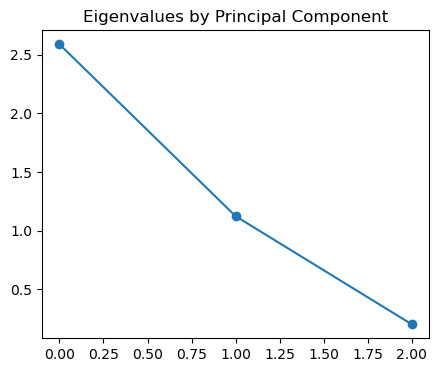

In [6]:
evals, evecs = np.linalg.eig(covmat)

idx = evals.argsort()[::-1]  
evals = evals[idx]
evecs = evecs[:,idx]

plt.figure(figsize=(5,4))
plt.title('Eigenvalues by Principal Component')
plt.plot(range(3), evals, '-o');

The eigenvalues are in units of variance. We can divide by the sum to normalize them, representing percent of variance explained, if we wish.

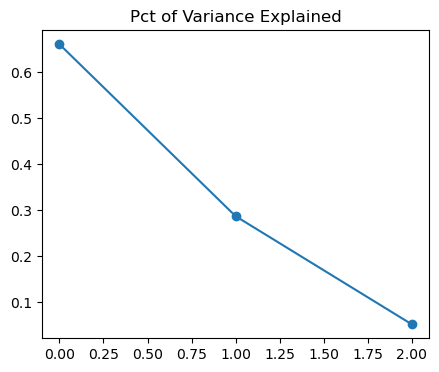

In [7]:
pctvar = evals / sum(evals)

plt.figure(figsize=(5,4))
plt.title('Pct of Variance Explained')
plt.plot(range(3), pctvar, '-o');

# Scikit-Learn Implementation

Let's check our results against the scikit-learn implementation, from the <code>decomposition</code> module. We'll import the class, instantiate and fit it, and then call the <code>explained_variance_ratio_</code> method, before comparing it to the results obtained from normalizing our earlier-found eigenvalues.

In [8]:
from sklearn.decomposition import PCA

pca = PCA()
pca = pca.fit(A)
pca.explained_variance_ratio_

array([0.66093631, 0.2870834 , 0.05198029])

In [9]:
# normalized eigenvalues calculated earlier
pctvar

array([0.66093631, 0.2870834 , 0.05198029])

It's a match. The eigenvectors of the sklearn implementation can be retrieved with the <code>components_</code> property.

In [10]:
pca.components_

array([[-0.44025895,  0.61656716, -0.65269977],
       [ 0.02915065, -0.71674307, -0.69672779],
       [-0.89739751, -0.32576727,  0.29757922]])

And the vectors we saw earlier were:

In [11]:
evecs

array([[ 0.44025895, -0.02915065, -0.89739751],
       [-0.61656716,  0.71674307, -0.32576727],
       [ 0.65269977,  0.69672779,  0.29757922]])

The results are a match except for 1) the orientation of results is transposed, and 2) there are differences in sign. The former is necessary to keep in mind when working with the data, and the latter is no big deal. The vector is a line of arbitrary length which points in both the negative and positive direction, so we know what we need to for our purposes, which is the direction.

# Reconstruction of Data

Let $X_{new}$ be the data matrix with $n$ rows (data points) and $p$ columns. After subtracting the mean vector $\mathbf{\mu}$, we get the centered data matrix $\mathbf{X}$. Let $\mathbf{V}$ be the $p \times k$ eigenvectors that we want to use. Then, the $n \times k$ matrix of PCA projections (scores) will be $\mathbf{Z = XV}$.

## The Iris Dataset

Let's get some slightly more interesting data. We'll work with pictures in a moment, but first, a more classical case to demonstrate reconstruction after dimension reduction, using the Iris dataset.

In [12]:
import sklearn.datasets
X = sklearn.datasets.load_iris().data

In [13]:
pca = sklearn.decomposition.PCA()
pca = pca.fit(X)
pca.explained_variance_

array([4.22824171, 0.24267075, 0.0782095 , 0.02383509])

Note that the sklearn implementation subtracts the mean vector for us; we'll get the same results as above, even if centered (as demonstrated directly below).

In [14]:
mu = np.mean(X, axis=0)
X_cent = X - mu
pca = sklearn.decomposition.PCA()
pca = pca.fit(X_cent)
pca.explained_variance_

array([4.22824171, 0.24267075, 0.0782095 , 0.02383509])

We'll reconstruct it using a manual method first, and then use the built-in method of the scikit-learn implementation. I'll start by including all 4 components, so as to prove that this operation will reconstruct the original data.

In [15]:
X_cent = X - mu
n_comp = 4
X_hat = np.dot(pca.transform(X_cent)[:,:n_comp], pca.components_[:n_comp,:])
X_hat += mu

X_hat.shape

(150, 4)

The first 5 rows of reconstructed data:

In [16]:
X_hat[0:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

The first 5 rows of the original dataset:

In [17]:
X[0:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

Alternatively, we can compress the data, opting to keep only the first two principal components (as an example).

In [18]:
n_comp = 2
X_hat = np.dot(pca.transform(X_cent)[:,:n_comp], pca.components_[:n_comp,:])
X_hat += mu
np.round(X_hat[0:5],2)

array([[5.08, 3.52, 1.4 , 0.21],
       [4.75, 3.16, 1.46, 0.24],
       [4.7 , 3.2 , 1.31, 0.18],
       [4.64, 3.06, 1.46, 0.24],
       [5.07, 3.53, 1.36, 0.2 ]])

Notice that the values are different, but quite close to the un-transformed originals.

## The Olivetti Faces Dataset

I'll import the Olivetti Faces dataset and visualize the first 20 images.

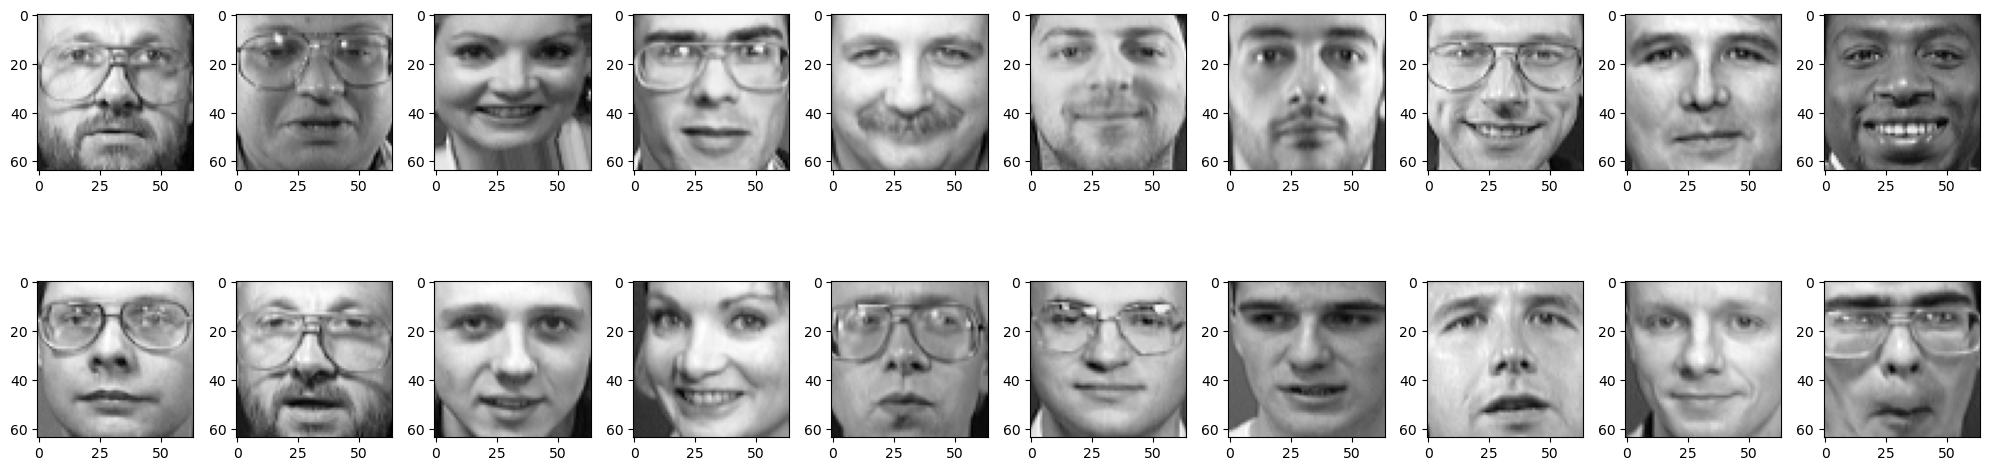

In [20]:
from sklearn.datasets import fetch_olivetti_faces
faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True)
n_samples, n_features = faces.shape

fig, axes = plt.subplots(2, 10, figsize=(20, 6))
nrows, ncols = int(np.sqrt(n_features)), int(np.sqrt(n_features))
for i in range(20):
    axes[i//10, i %10].imshow(np.reshape(faces[i], (nrows,ncols)), cmap='gray');
    
plt.tight_layout()

Then, check out the eigenspectra.

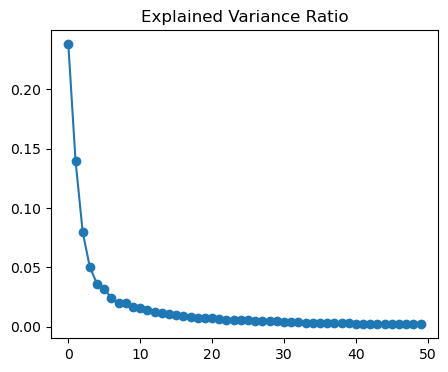

In [21]:
pca = sklearn.decomposition.PCA()
pca.fit(faces)
plt.figure(figsize=(5,4))
plt.title('Explained Variance Ratio')
plt.plot(pca.explained_variance_ratio_[0:50], '-o');

The first 20 components explain the vast majority of the variance. I'll reconstruct the images using only those components and print those dimension-reduced results.

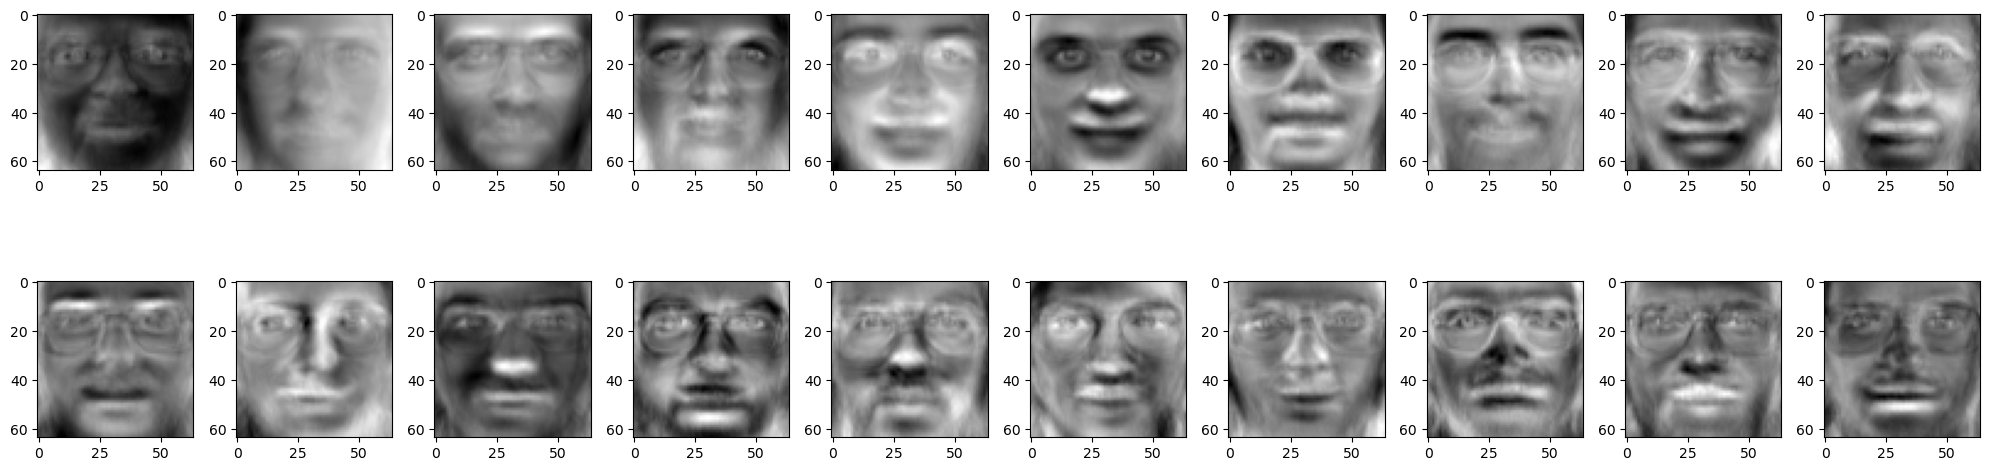

In [22]:
n_comp = 20

pca = PCA(n_components=n_comp)
pca = pca.fit(faces)
comps = pca.components_[:n_comp]

fig, axes = plt.subplots(2, 10, figsize=(20, 6))
nrows, ncols = int(np.sqrt(n_features)), int(np.sqrt(n_features))
for i in range(20):
    axes[i//10, i %10].imshow(np.reshape(comps[i], (nrows,ncols)), cmap='gray');
    
plt.tight_layout()

A tad ghoulish, but from a modeling perspective, perhaps this is optimally informative, given the reduced feature space.

# Advantages and Limitations

PCA is an unsupervised learning task, so it can be used to gain insight from data without designating a target variable. It is also a linear method, which generally aids in interpretability, but hinders flexibility. 

The orthogonality constraint can be helpful to some models, by ‘fanning’ the data out, but detrimental to others in that it makes for quite a drastic transformation. It does potentially offer a solution for dealing with large numbers of features, or correlated features that you wish to combine. The focus on maximizing variance of each component can also be quite useful, though less-so if variance alone does not provide the nature of insight being sought.

# Scikit-Learn Implementation Details

<code>sklearn.decomposition.PCA(n_components=None, *, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', n_oversamples=10, power_iteration_normalizer='auto', random_state=None)</code>

## Parameters

- <code>n_components</code> (default=all): if >= 1, the number of components to keep. If between 0 and 1, the total percent of variance to be explained by all components kept.

- <code>whiten</code> (default=False): whether the components_ vectors are multiplied by the square root of n_samples and divided by the singular values to ensure uncorrelated outputs with unit component-wise variances.

- <code>svd_solver</code> (default='auto'): PCA in sklearn is solved via SVD. This selects the solver (‘auto’ will base selection upon the data).

## Attributes

- <code>n_components_</code>: number of components kept.

- <code>singular_values_</code>: the singular values corresponding to each of the selected components.

- <code>explained_variance_</code>: the amount of variance explained by each of the selected components.

- <code>explained_variance_ratio_</code>: the amount of variance explained by each of the selected components.

- <code>n_features_in</code>: number of features seen during fit.

## Methods

- <code>fit</code>: fit an instance of the model to the data.

- <code>fit_transform</code>: fit an instance of the model to the data, and apply the dimensionality reduction to the data.

- <code>inverse_transform</code>: transform the data back to its original space.

# What’s Next?

The next article in the series is on principal components analysis (PCA), which involves eigendecomposition upon a covariance matrix, and has some special properties, such as orthogonalizing components, and maximizing variance for each component under this constraint.

# References

- Cohen, M. X. (2021). Linear Algebra (1st ed.). SincXpress. 
https://sincxpress.com/books.html

- Brownlee, J. (2019). Basics of Linear Algebra for Machine Learning (2nd ed.). Machine Learning Mastery. 
https://machinelearningmastery.com/linear_algebra_for_machine_learning/

- Cohen, M. X. (2024, May 1). Complete linear algebra: Theory and implementation in code [Online Course]. Udemy. 
https://www.udemy.com/course/linear-algebra-theory-and-implementation/

- Cohen, M. X. (2024, May 1). PCA & multivariate signal processing, applied to neural data [Online Course]. Udemy. 
https://www.udemy.com/course/dimension-reduction-and-source-separation-in-neuroscience/

- (n.d.). PCA. Scikit-Learn.org. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

- Minhas, M. (2021). Visualizing feature vectors/embeddings using t-SNE and PCA. Towards Data Science. https://towardsdatascience.com/visualizing-feature-vectors-embeddings-using-pca-and-t-sne-ef157cea3a42

- Minhas, M. (2022). Intro to PCA, t-SNE & UMAP. Kaggle. https://www.kaggle.com/code/samuelcortinhas/intro-to-pca-t-sne-umap